In [61]:
%load_ext autoreload
%autoreload 2
from glucose_dataset import GlucoseDataset
from models import GlucoseModel
import torch
import numpy as np
from rockpool import TSEvent, TSContinuous
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import resampy
from snntorch.spikegen import to_one_hot

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


Experimental Parameters

In [62]:
# The number of points to interpolate between each sample to simulate continuous sampling
# Each sample is interpolated and presented for 1 second.
dt_per_sample = 128

# The number of channels used for population encoding. Each channel represents a different
# range of values. The number of channels should be a power of 2.
in_channels = 2**3

# The number of variant spike trains to generate. Each spike train is a different, but 
# represents the same continuous signal.
batch_size = 32

# The window of time to display in the plot
time_window = {'left': 1, 'right': 60*60*24}

Data Ops

In [63]:
ds = GlucoseDataset("datasets/diabetes_datasets.zip", sub_directory="Shanghai_T1DM")
sample_data = ds.__getitem__(1)[40:]
dt = ds.sample_interval

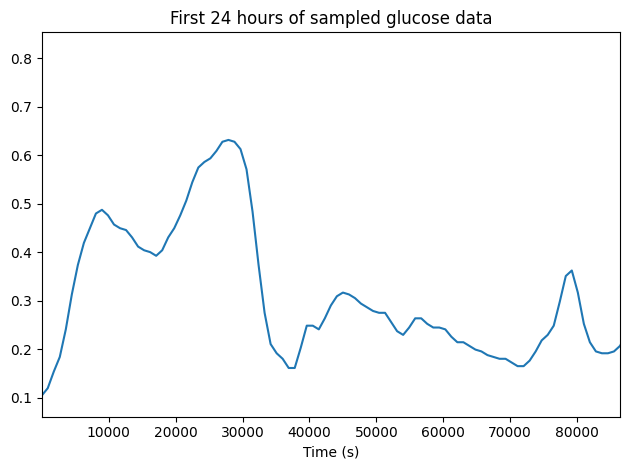

In [64]:
# Plot the time series
timeseries = TSContinuous.from_clocked(samples=sample_data, dt=ds.sample_interval) # type: ignore
timeseries.plot()
plt.title("First 24 hours of sampled glucose data")
plt.xlim(**time_window)
plt.tight_layout();

Interpolate to simulate continuous sampling

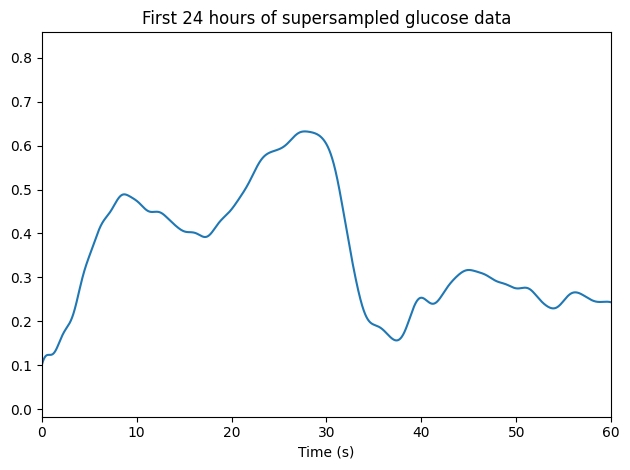

In [65]:
# Scale the timestep to something hardware compatible
dt_scaled = dt * 1e-3 / dt_per_sample

# Resample the data to simulate continuous sampling
new_times = np.linspace(timeseries.times[0], timeseries.times[-1], len(timeseries.samples) * dt_per_sample)
supersampled = resampy.resample(timeseries.samples, 1, dt_per_sample, axis=0, filter='kaiser_best')
timeseries_smoothed = TSContinuous.from_clocked(samples=supersampled, dt=dt_scaled)
timeseries_smoothed.plot()
plt.title("First 24 hours of supersampled glucose data")
plt.xlim(0, 60)
plt.tight_layout();

In [66]:
# gain = 0.2
# trial_spikes = []
# for i in range(batch_size):
#     trial_spikes.append(torch.rand_like(torch.tensor(timeseries_smoothed.samples)) < torch.tensor(timeseries_smoothed.samples) * gain)
# input_spikes = torch.stack(trial_spikes, dim=1).numpy()
# TSEvent.from_raster(input_spikes, dt_scaled, num_channels=batch_size, name='Poisson input events').plot()
# plt.xlim(0, 5)
# plt.tight_layout();
# print(input_spikes.shape)


In [67]:
model = GlucoseModel(1, 16, 1, dt=dt_scaled)

TorchSequential  with shape (1, 1) {
    LinearTorch '0_LinearTorch' with shape (1, 16)
    LIFTorch '1_LIFTorch' with shape (16, 16)
    LinearTorch '2_LinearTorch' with shape (16, 1)
    LIFTorch '3_LIFTorch' with shape (1, 1)
}


In [68]:
import rockpool.devices.xylo.syns61201 as x

spec = x.mapper(model.net.as_graph(), weight_dtype='float')

In [69]:
from rockpool.transform import quantize_methods as q

# Quantize
spec.update(q.global_quantize(**spec))

config, is_valid, msg = x.config_from_specification(**spec)
if not is_valid:
    print(msg)

In [70]:
simulator = x.XyloSim.from_config(config)

In [71]:
# - Evolve the input over the network, in simulation
out, _, r_d = simulator(input_spikes[:,0,:], record=True)

# - Show the internal state variables recorded
print(r_d.keys())

dict_keys(['Vmem', 'Isyn', 'Isyn2', 'Spikes', 'Vmem_out', 'Isyn_out'])


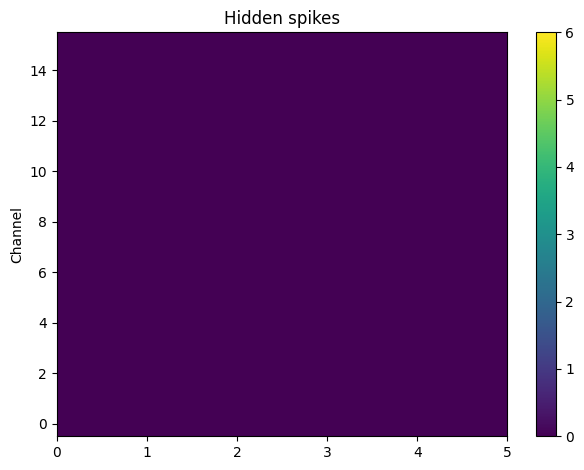

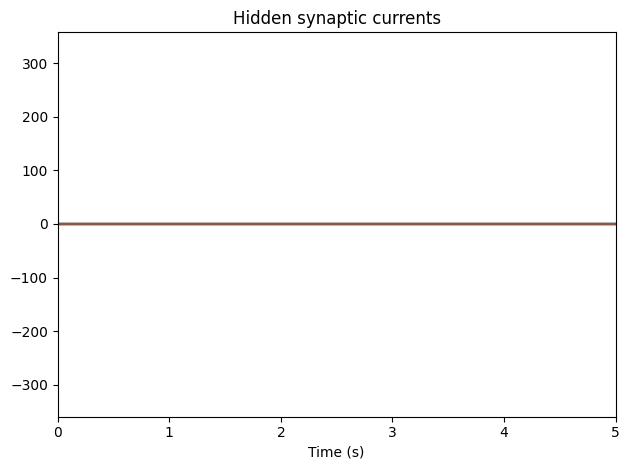

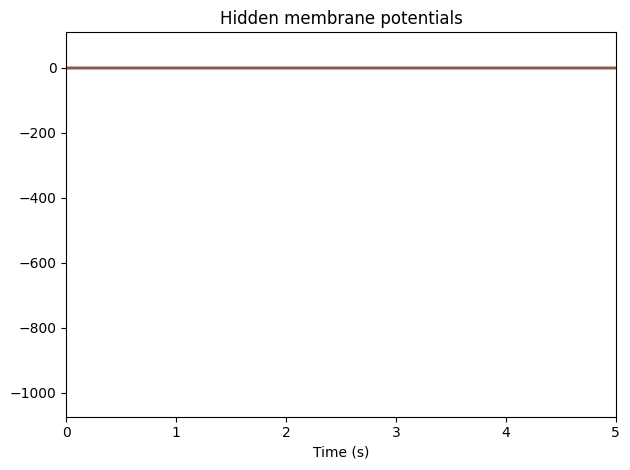

In [72]:
plt.figure()
plt.imshow(r_d['Spikes'].T, aspect='auto', origin='lower')
plt.title('Hidden spikes')
plt.ylabel('Channel')
plt.xlim(0, 5)
plt.colorbar()
plt.tight_layout()
plt.show();

plt.figure()
TSContinuous(new_times, r_d['Isyn'], name='Hidden synaptic currents').plot()
plt.xlim(0, 5)
plt.tight_layout()
plt.show();

plt.figure()
TSContinuous(new_times, r_d['Vmem'], name='Hidden membrane potentials').plot()
plt.xlim(0, 5)
plt.tight_layout()
plt.show();